# Waving Goodbye to Subsequent COVID-19 Waves
### Using data from the Government of Canada on daily cases and daily vaccinations to model the end of the pandemic in Canada

**Disclaimer**: Please note that this project is just for fun and for my personal learning. Although the data is publicly retrievable, these analyses should __not__ be used to guide real-world decisions. Models use an idealized input and are not adequate representations of human behaviour. 

## Part 1. Data Retrieval
The first thing to do is to retrieve data from the Government of Canada websites

In [28]:
# Import dependencies
import missingno as msno
import os
import pandas as pd
import urllib


In [17]:
# Make a directory to hold the data if it doesn't exist
if not os.path.exists("./data"):
    os.makedirs("./data")

So now we will have to define a function that takes as input a remote URL containing our desired data_source and our output filename.

In [18]:
def download(remote_url: str, local_file: str):
    """Download a file from a remote URL unless the local_file already exists.
    Returns the local_file name."""
    if not os.path.exists(local_file):
        print(f"Retrieving {local_file}...")
        response = urllib.request.urlretrieve(remote_url, local_file)
        return local_file

In [19]:
# Set target datasets to download for our database
# Thankfully, these databases are in .csv format
url_prefix = "https://health-infobase.canada.ca/src/data/covidLive/"
files_list = ['covid19-download.csv', 'covid19-data-dictionary.csv', 'vaccination-coverage-map.csv']

# Then download the datasets
for file in files_list:
    if not os.path.exists("./data/" + file):
        download(url_prefix + file, "./data/" + file)

Now that we have our datasets, let's transfer them into a dataframe and see what's inside:

In [20]:
# Read all our data into separate dataframes
data_dict = pd.read_csv('./data/covid19-data-dictionary.csv')
epi_data = pd.read_csv('./data/covid19-download.csv')
vax_data = pd.read_csv('./data/vaccination-coverage-map.csv')

In [21]:
# Take a look at what's inside one of the dataframes
epi_data.head(10)

,pruid,prname,prnameFR,date,update,numconf,numprob,numdeaths,numtotal,numtested,...,ratedeaths_last14,numtotal_last7,ratetotal_last7,numdeaths_last7,ratedeaths_last7,avgtotal_last7,avgincidence_last7,avgdeaths_last7,avgratedeaths_last7,raterecovered
0,35,Ontario,Ontario,2020-01-31,NaN,3,0.0,0.0,3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,59,British Columbia,Colombie-Britannique,2020-01-31,NaN,1,0.0,0.0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,1,Canada,Canada,2020-01-31,NaN,4,0.0,0.0,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,35,Ontario,Ontario,2020-02-08,NaN,3,0.0,0.0,3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,59,British Columbia,Colombie-Britannique,2020-02-08,NaN,4,0.0,0.0,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
5,1,Canada,Canada,2020-02-08,NaN,7,0.0,0.0,7,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
6,35,Ontario,Ontario,2020-02-16,NaN,3,0.0,0.0,3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
7,59,British Columbia,Colombie-Britannique,2020-02-16,NaN,5,0.0,0.0,5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
8,1,Canada,Canada,2020-02-16,NaN,8,0.0,0.0,8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
9,35,Ontario,Ontario,2020-02-21,NaN,3,0.0,0.0,3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


It looks like `data_dict` is a dictionary for the column headers for `epi_data`. Let's define them outside here:
| Column Header | Variable Name | Description |
| --- | --- | --- |
| **pruid** | Provincial ID | 1=Canada <br> 10=Newfoundland and Labrador <br> 11=Prince Edward Island <br> 12=Nova Scotia <br> 13=New Brunswick <br> 24=Quebec <br> 35=Ontario <br> 46=Manitoba <br> 47=Saskatchewan <br> 48=Alberta <br> 59=British Colombia <br> 60=Yukon <br> 61=Northwest Territories <br> 62=Nunavut <br> 99=Repatriated Travellers |
| **prname** | Province name | Name of P/T (English) |
| **prnameFR** | Province name | Name of P/T (French) |  
| **date** | Report date | Date reported by P/T |
| **numconf** | Number of confirmed cases | Number of confirmed cases in each P/T (Canada= sum of all P/Ts) |
| **numprob** | Number of probable cases | Number of probable cases in each P/T (Canada= sum of all P/Ts) | 
| **numdeaths** | Number of deaths | Number of deaths in each P/T (Canada= sum of all P/Ts) |
| **numtotal** | Total number of cases | Calculated by number of confirmed cases plus number of probable cases (numconf+numprob) |
| **numtested** | Number of individuals tested | Number of individuals tested in each P/T, as reported from the National Microbiology Laboratory |
| **numrecover** | Number of recovered cases | Number of recovered cases in each P/T (Canada=sum of all P/Ts) | 
| **percentrecover** | Percentage of recovered cases | Calculated by the number of recovered cases for a P/T divided by the total number of confirmed cases for that P/T [(numrecover/numtotal) x100] |
| **ratetested** | Testing rate per one million population | Calculated by the number of individuals tested for a P/T divided by the population of that P/T [(numtested/population) x1,000,000] |
| **numtoday** | Number of new cases since last update | Number of total counts from last update subtracted from total counts of current update |
| **percentoday** | Percent change since last update | Calculated by the number of new cases divided by the previous update's total number of cases [(numtoday/numtotal of previous update)x100] |
| **ratetotal** | Case rate per one hundred thousand population | Calculated by the total number of cases for a P/T divided by the population of that P/T[(numtotal/population) x100,000] |

In [24]:
# Describe the rest of the epidemiolofical data
epi_data.describe()

,pruid,update,numconf,numprob,numdeaths,numtotal,numtested,numtests,numrecover,percentrecover,...,ratedeaths_last14,numtotal_last7,ratetotal_last7,numdeaths_last7,ratedeaths_last7,avgtotal_last7,avgincidence_last7,avgdeaths_last7,avgratedeaths_last7,raterecovered
count,8817.000000,3835.000000,8.817000e+03,6312.000000,8698.000000,8.817000e+03,4.905000e+03,8.817000e+03,8.293000e+03,8089.000000,...,7994.000000,8565.000000,7994.000000,8565.000000,7993.000000,8565.000000,7994.000000,8565.000000,7994.000000,8233.000000
mean,39.148917,0.827379,9.028463e+04,1.039924,2149.802943,9.028493e+04,8.376140e+05,2.536910e+06,8.894476e+04,88.399038,...,1.045198,2724.368710,38.219791,46.250321,0.528080,389.184005,5.460044,6.591944,0.075319,5.054696
std,26.268398,0.377968,2.416792e+05,16.599030,5054.953963,2.416792e+05,2.277015e+06,6.564642e+06,2.359981e+05,16.161130,...,2.028306,7227.448801,62.931654,134.275480,1.071601,1032.497572,8.990201,19.189889,0.153105,12.732837
min,1.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-49.250000
25%,12.000000,1.000000,1.010000e+02,0.000000,0.000000,1.020000e+02,4.464000e+03,9.457000e+03,1.280000e+02,86.190000,...,0.000000,1.000000,1.152500,0.000000,0.000000,0.000000,0.162500,0.000000,0.000000,0.000000
50%,46.000000,1.000000,1.266000e+03,0.000000,24.000000,1.266000e+03,5.729200e+04,1.662610e+05,1.370000e+03,93.740000,...,0.180000,57.000000,8.890000,1.000000,0.080000,8.000000,1.270000,0.000000,0.010000,0.510000
75%,60.000000,1.000000,5.262400e+04,0.000000,1210.750000,5.262400e+04,3.741220e+05,1.132208e+06,5.088600e+04,97.620000,...,1.160000,1851.000000,54.510000,22.000000,0.570000,264.000000,7.787500,3.000000,0.080000,5.120000
max,99.000000,1.000000,1.676846e+06,833.000000,28468.000000,1.676846e+06,1.748336e+07,4.483634e+07,1.613576e+06,100.780000,...,17.400000,61113.000000,779.430000,1236.000000,9.000000,8730.000000,111.350000,177.000000,1.290000,438.430000


In [25]:
# Describe the vaccination coverage data
vax_data.describe()

,pruid,numtotal_atleast1dose,numtotal_partially,numtotal_fully,proptotal_atleast1dose,proptotal_partially,proptotal_fully,numeligible_atleast1dose,numeligible_partially,numeligible_fully,propeligible_atleast1dose,propeligible_partially,propeligible_fully,numweekdelta_atleast1dose,numweekdelta_fully,propweekdelta_atleast1dose,propweekdelta_fully
count,581.000000,5.810000e+02,5.720000e+02,5.670000e+02,581.000000,572.000000,567.000000,2.520000e+02,2.430000e+02,2.520000e+02,252.000000,243.000000,252.000000,0.0,0.0,0.0,0.0
mean,34.984509,2.138304e+06,8.889820e+05,1.286335e+06,40.380448,14.215787,26.263016,3.822837e+06,1.076337e+06,2.767270e+06,79.587738,18.961564,59.388095,NaN,NaN,NaN,NaN
std,21.698278,5.212413e+06,2.486036e+06,3.963264e+06,29.335819,15.100574,27.486824,7.012609e+06,2.725029e+06,5.590700e+06,6.331432,18.020234,22.690924,NaN,NaN,NaN,NaN
min,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,1.779800e+04,1.446000e+03,1.439700e+04,60.480000,3.680000,3.090000,NaN,NaN,NaN,NaN
25%,12.000000,2.501100e+04,5.855750e+03,1.129750e+04,5.900000,3.472500,1.700000,1.252200e+05,2.206950e+04,4.661575e+04,74.975000,7.085000,49.567500,NaN,NaN,NaN,NaN
50%,46.000000,2.257700e+05,7.904800e+04,4.287800e+04,47.340000,7.625000,8.980000,7.458625e+05,1.176420e+05,5.571660e+05,80.445000,9.690000,68.230000,NaN,NaN,NaN,NaN
75%,59.000000,9.839350e+05,4.900578e+05,5.530705e+05,68.270000,21.162500,55.295000,3.754864e+06,6.571130e+05,2.630161e+06,84.592500,24.860000,76.112500,NaN,NaN,NaN,NaN
max,62.000000,2.909145e+07,1.996076e+07,2.718725e+07,82.710000,60.950000,75.590000,2.898585e+07,1.993665e+07,2.712128e+07,92.040000,68.370000,85.020000,NaN,NaN,NaN,NaN


Let's take a look at all the missing data in our dataframes.

<AxesSubplot:>

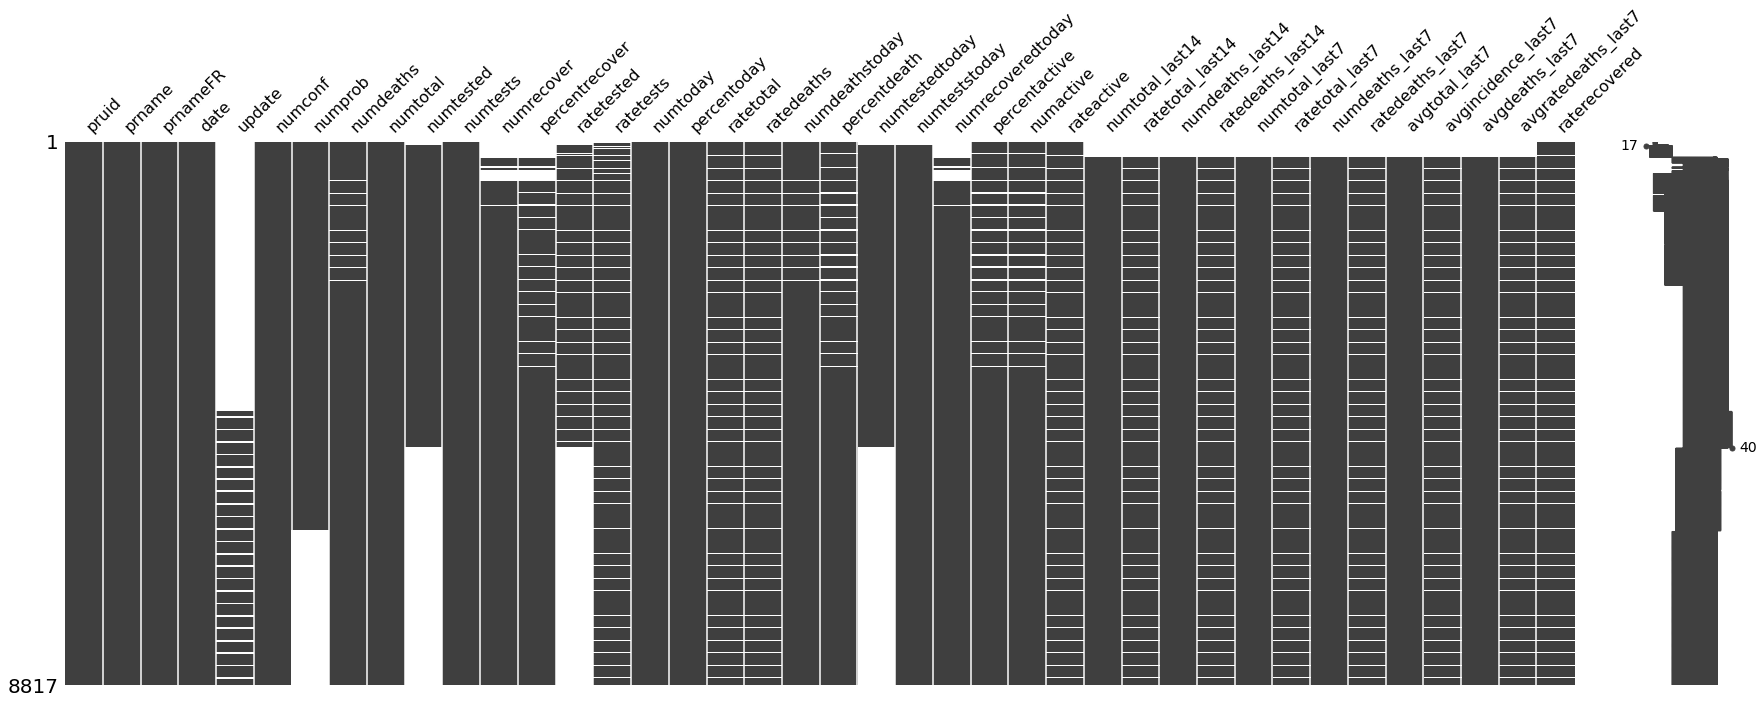

In [29]:
# Plot graphic of missing data for epi_data
msno.matrix(epi_data, figsize=(30, 10))

<AxesSubplot:>

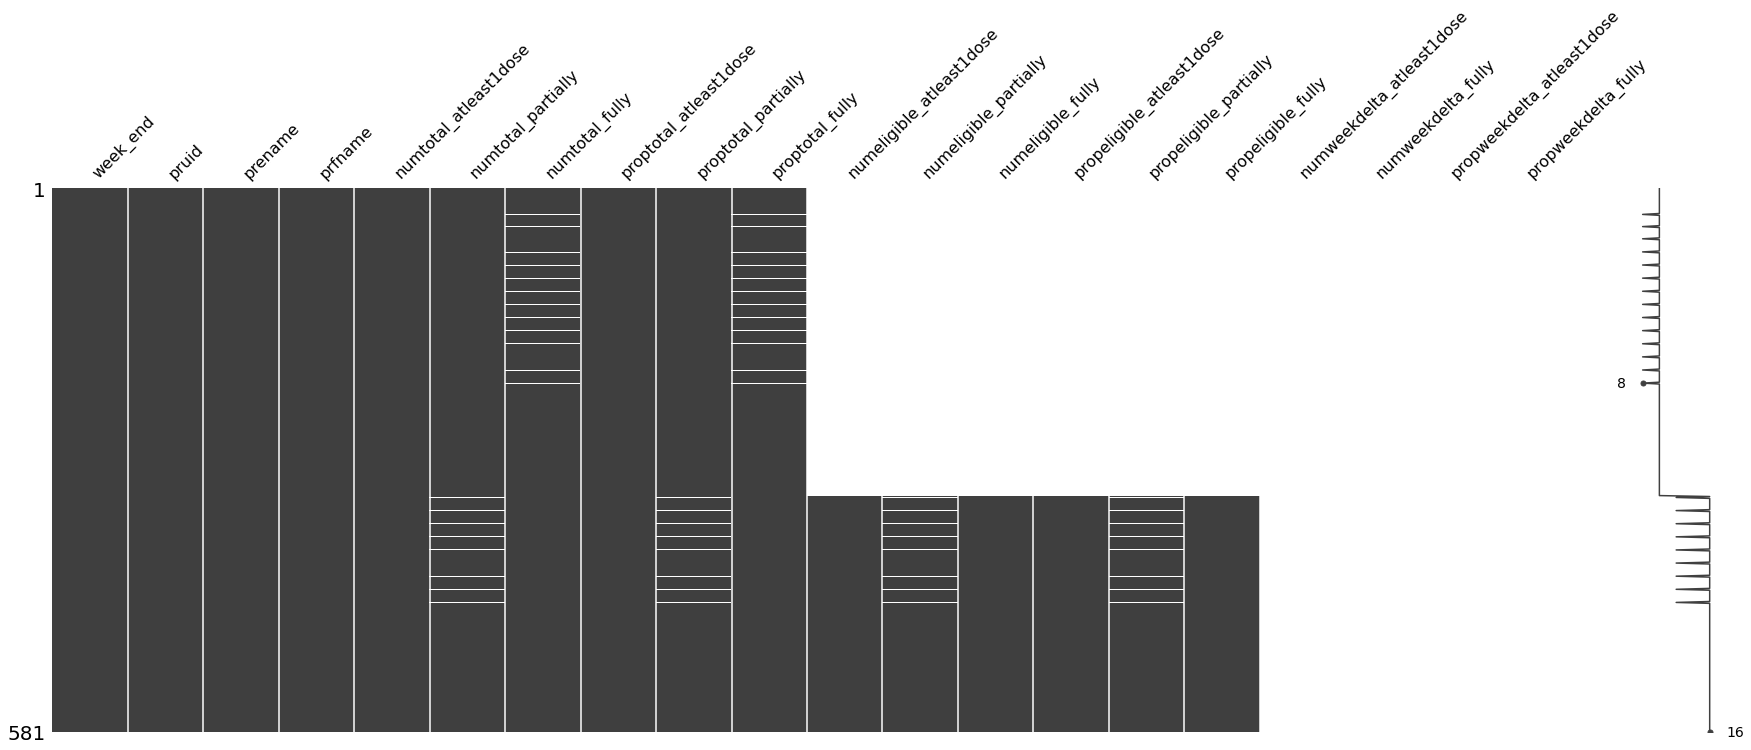

In [30]:
# Plot graphic for missing data for vax_data
msno.matrix(vax_data, figsize=(30, 10))